# Cloud effects on ICESat-2 data,  and Data Filtering

---

## Overview

The ICESat-2 land-ice product (ATL06) was designed to measure the heights of snow and ice surfaces.  But when we're making these measurements, sometimes clouds get in the way, and the measured heights aren't as precise or accurate as we would like. This tutorial covers some of the reasons you might see weird results over ice when clouds start to blot out the surface signals.  The learning objectives I'd like to get to are:

* Understanding how clouds affect laser-altimetry signals

* Recognizing how these effects are manifest in the ATL06 product

* Gaining familiarity with the ATL06 parameters that can identify cloudy returns


### Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [pandas](https://foundations.projectpythia.org/core/pandas/pandas) | Necessary | ICESat-2 data in this tutorial will appear as geopandas dataframes |
| [numpy/matplotlib](https://foundations.projectpythia.org/core/matplotlib) | Necessary | We will do our plotting with matplotlib|
| [mission-overview.ipynb](mission-overview.ipynb) | Necessary | Here is where to go to understand the ICESat-2 mission and its goals |

- **Time to learn**:  30 min.

:::{tip}
This tutorial was developed on CryoCloud under the default environment.  If you're using CryoCloud, you'll need to pick an instance that uses at least 7 GB of memory to keep the kernel from running out of memory and resetting.
:::


---

## Imports

We'll use the [SlideRule](https://slideruleearth.io) computational platfrom to access ATL06 segments and ATL03 photons, and will use an image of the ice shelf from the REMA project to visualize the location.

In [1]:
# General packages for the tutorial
import pprint
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
%matplotlib widget

# packages needed for the basemap 
import PIL.Image
import urllib.request
import urllib.parse

#sliderule
from sliderule import icesat2
import sliderule
# We'll initialize sliderule with the verbosity flag set to 'False.'  If you like to see lots of text scrolling by, set it to 'True'
icesat2.init("slideruleearth.io", False)

# Background: ATL06 signal processing

<img src="assets/filtering/ATL06_segment_model.png"  width=600 height=600 alt="ATL06 segment model"/>

Recall that ATL06 gives us surface heights based on the heights of collections of photons in a 40-m (horizontal) by w_surface_window (vertical) window.  It uses a variety of techniques to shrink the window to the smallest size that contains the surface without clipping off any signal photons.  


There's a general philosophy that went into the design of ATL06:
1. Use the best available information to identiy the surface
2. If there's a chance that we've found a weak surface return, report it
3. Provide enough parameters that users can decide which returns are worth using, and which are not

When there are no thick clouds between ICESat-2 and the surface, finding the surface return and reporting its height is straightforward: ATL03 provides a tight cluster of high-confidence photons, and ATL06 calculates a weighted average of their heights.

Once clouds start to block some of the laser light, the number of photons that return to ATLAS from each return becomes progressively smaller.  Unfortunately, even if there are no laser photons to measure, during daylight there is no shortage of other photons to track, which come primarily from sunlight reflecting ground and from clouds.  ATLAS does a very good job of filtering out almost all of these photons, but on a sunny day, over a white surface, the measured background rate can be as high as 12 MHz.  Converting to dimensions that we'll be seeing this is:
$$ 
    \frac{1.2\times10^7 photons}{second} \times \frac{1 second}{1.5\times10^8 m} = \frac{1 photon}{12.5 m}
$$
This doesn't sound like a lot, but over a 10-meter-high window that's 40 m long (typical for the kind of windows you might use to look for the surface if you didn't know where to find it) we can expect to find 45 photons.

Unlike surface-return photons, background photons are uniformally distributed in height, and any clustering of these photons will be due to random chance.  When the signal quality is marginal, ATL03 may flag photons only as low- and medium- confidence for a particular segment, or may flag no photons at all.  If ATL03 hasn't told ATL06 which photons are the surface, the algorithm uses a backup signal-finding strategy that initializes surface finding using the strongest cluster of photons available.  It then attempts to converge its surface window on a tight cluster of photons.  This occasionally works, but if there really is no signal, the size of the window generally remains large, and we can evaluate the results based on the signal-to-noise ratio (SNR) of whatever ends up inside the window.  Only those segments with at least 10 photons, for which the probability of converging to an SNR equal to the observed SNR or better for random-noise inputs is less thatn 5% are reported.  This cuts down on false positives considerably. 

Let's take a look at some data from Antarctica to see what different problematic data might look like.


## Geographic Setting

We'll be working on Cook Ice Shelf, a heavily crevassed and rifted ice shelf that drains East Antarctica.  I've defined a polygon that covers the transition between grounded ice (at the top) floating ice (within the polygon).  The region we'll be working in is about 70 km x 60 km, and is covered by 20-30 ICESat-2 repeat tracks.  We can get an image of the shelf from the ArcticDEM project, using a urllib-based request.  Note: This code can be used to obtain a basic image for almost anywhere in the Arctic and Antarctic, which might be helpful in other work.

The location information is stored in a kml file in the assets directory, but you can substitute your own kml if you'd like to look at data from somewhere else.  Just make sure not to make your query too large to avoid running out of memory.

Text(0.5, 0, 'polar-stereographic N, m')

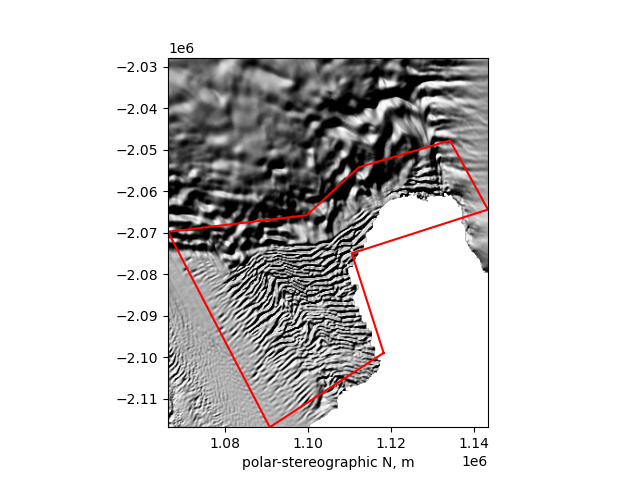

In [ ]:
# read in a polygon defining our area of interest:
df = gpd.read_file('assets/filtering/Cook_subset.kml')
geom_xy = df.to_crs(3031).geometry[0]
geom_ll = df.geometry[0]

# get a shaded relief DEM to use as a basemap. This uses the ArcticDEM image server.

HOST = 'https://elevation2.arcgis.com/arcgis/rest/services/Polar/AntarcticDEM/ImageServer/exportImage?'
params = []
params.append('bboxSR=3031')
params.append('imageSR=3031')
params.append('format=jpgpng')
params.append('noDataInterpretation=esriNoDataMatchAll')
params.append('f=image')

[xmin, xmax], [ymin, ymax] = np.array(geom_xy.bounds).reshape(2,2).T
# include a little bit more area at the top:
ymax += 2.e4 
bbox = f'{xmin},{ymin},{xmax},{ymax}'
params.append(f'bbox={urllib.parse.quote(bbox)}')

image_service_url = HOST + '&'.join(params)
shaded_relief_img = {'data': np.array(PIL.Image.open(urllib.request.urlopen(image_service_url))),
    'extent':[xmin, xmax, ymin, ymax]}
plt.figure()
plt.imshow(shaded_relief_img['data'], extent=shaded_relief_img['extent'])
x_poly, y_poly, _ = [*np.c_[geom_xy.exterior.coords].T]
plt.plot(x_poly, y_poly,'r')

plt.gca().set_xlabel('polar-stereographic E, m')
plt.gca().set_xlabel('polar-stereographic N, m')

## ICESat-2 data over Cook Ice Shelf

For this tutorial, we'll use the SlideRule service to download ATL06 (height measurements) and ATL03 (photon clouds).  SlideRule offers a quick and efficient way to search for and access data for limited areas of the ice sheet without the need to subset or download entire granules of data.  

### Preliminary data download

Let's begin by looking at the distibution of tracks for the region, using the ATL06 (land-ice height) product. We'll first request a subset of data covering 2020.  To run SlideRule, we need a polygon (defined as a list of dictionaries, each of which has a 'lat' and a 'lon' element) and a start and stop time.  We'll use the ATL06sp endpoint, which subsets all the granules in the region for a standard set of ATL06 fields.  The polygon we're using comes from a kml file called Cook_subset.kml, which is in the assets/filtering directory.  You can substitute your own file if you want to work on a different area.

In [3]:
# Define a polygon in sliderule format.
poly=[{'lat':jj[1], 'lon':jj[0]} for jj in geom_ll.exterior.coords]

#Define the request (a dictionary of parameters, 
#see: https://slideruleearth.io/web/rtd/user_guide/icesat2.html#parameters
sliderule_parms= {
    "poly":poly,
    "t0": "2020-01-01T01:00:00Z",
    "t1": "2021-01-01T01:01:01Z",
  }
# submit the request, which should take 10-15 seconds
D6=icesat2.atl06sp(sliderule_parms)
# transform the output to polar stereographic coordinates
D6.to_crs(3031, inplace=True)


We can take a look at the data that SlideRule returned to see what fields are present:

In [4]:
D6

,spot,dh_fit_dx,x_atc,atl06_quality_summary,h_li,n_fit_photons,segment_id,sigma_geo_h,gt,tide_ocean,...,y_atc,r_eff,cycle,w_surface_window_final,h_robust_sprd,bsnow_conf,seg_azimuth,bsnow_h,h_li_sigma,geometry
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02 19:53:02.195757568,4,-0.097162,2.771537e+07,1,96.577782,24,1384275,5.025305,30,NaN,...,44.051380,0.112080,6,6.681315,0.861015,-4,-173.167130,NaN,0.570025,POINT (1134789.443 -2067157.569)
2020-01-02 19:53:02.209907968,4,-3.340194,2.771547e+07,1,NaN,174,1384280,NaN,30,NaN,...,NaN,NaN,6,85.177063,3.689145,-4,-173.166962,NaN,NaN,POINT (1134752.635 -2067064.229)
2020-01-02 19:53:02.269107712,2,-0.628042,2.771601e+07,1,NaN,32,1384307,NaN,50,NaN,...,NaN,NaN,6,16.026264,0.864407,-4,-173.166290,NaN,NaN,POINT (1137687.637 -2065298.619)
2020-01-02 19:53:02.291602432,4,0.034806,2.771605e+07,1,-28.034241,22,1384309,5.004794,30,NaN,...,43.920086,0.091685,6,6.711609,1.118602,-4,-173.166031,NaN,0.727074,POINT (1134534.808 -2066524.676)
2020-01-02 19:53:02.308643328,2,-0.041310,2.771629e+07,1,NaN,32,1384321,NaN,50,NaN,...,NaN,NaN,6,11.799726,1.966621,-4,-173.165833,NaN,NaN,POINT (1137583.486 -2065037.715)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 02:32:19.517601280,2,0.016789,2.773431e+07,0,152.665161,131,1385226,0.156103,20,NaN,...,3310.738037,1.488532,10,3.000000,0.114252,-2,-173.121323,75.705276,0.027166,POINT (1124610.332 -2050692.711)
2020-12-31 02:32:19.520413952,2,0.013516,2.773433e+07,0,152.956726,124,1385227,0.148099,20,NaN,...,3310.662109,1.355845,10,3.000000,0.144688,-2,-173.121292,76.277420,0.028296,POINT (1124602.953 -2050674.066)
2020-12-31 02:32:19.523228672,2,0.013440,2.773435e+07,0,153.296890,124,1385228,0.148106,20,NaN,...,3310.520752,1.329513,10,3.000000,0.170934,-2,-173.121262,76.849426,0.039525,POINT (1124595.6 -2050655.41)


There are 21 columns here, which describe:

* segment location (geometry)

* segment location along-track coordinates ( x_atc, y_atc )

* surface height and accuracy (h_li, h_li_sigma, atl06_quality_summary) 

* surface slope (dh_fit_dx, dh_fit_dy)

* signal (r_eff, n_fit_photons)

* track and timing parameters (cycle, gt, cycle, spot, delta_time)

The list of fields is designed to cover almost all users' needs, and we'll only end up using a few of them in this tutorial.  Let's look at the elevations (h_li) that came back in the current request in map view.

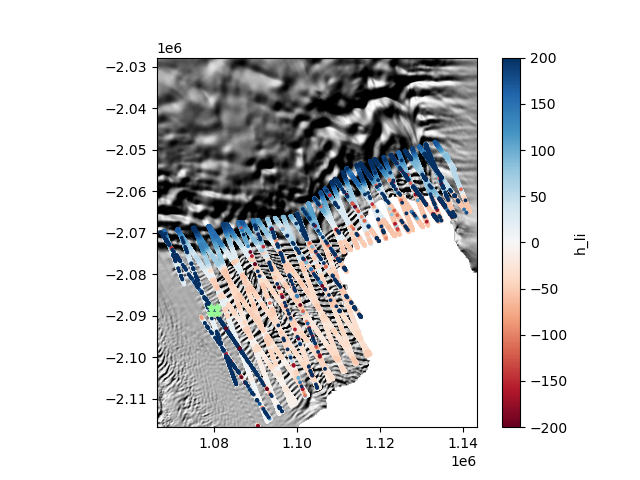

In [5]:
plt.figure()
ax_scat = plt.gca()
plt.imshow(shaded_relief_img['data'], extent=shaded_relief_img['extent'])

xx=np.array(D6.geometry.x)
yy=np.array(D6.geometry.y)
hh = np.array(D6.h_li)

# sort the data by abs(height) to make the outliers show up
ii=np.argsort(np.abs(hh))
ii=ii[np.isfinite(hh[ii])]
h_scat=plt.scatter(xx[ii], yy[ii], 3,  c=hh[ii], clim=[-200, 200], cmap='RdBu')
plt.colorbar(h_scat, label='h_li')

# suggested area to look at a poorly performing segment:
xl, yl = [np.array([1079194.72014081, 1080624.2833137 ]), np.array([-2089358.21884508, -2088030.7673274 ])]

plt.plot(xl[[0, 0, 1, 1, 0]], yl[[0, 1, 1, 0, 0]],'--', color='palegreen', marker='*', linewidth=2)

We can see on this plot that most of the surface heights are close to sea level, but a few tracks are reporting heights that are probably far too high.

### Selecting a track that has cloud problems

If you see a plot like this where there is a track that has problems, you need to figure out which track is affected.  To do this, you need to know which RGT (repeat ground track) has the problem, and which beams from that track are affected.

One way to do this is to use the zoom tool to find a track with large positive h_li values, and capture the axes x_lim and y_lim properties, then use the dataframe's _cx_ method to capture the subset of the dataframe within the axes.  You can do this by setting _'interactive'_ to _True_ in the next cell.

For puruposes of making the tutorial run without any interaction, I've also defined some limits in the next cell, and I'll be talking about the results that come from those limits.

:::{tip}
The next cell is where you can change the _'interactive'_ variable to _True_, and use the zoom tool to find different tracks for which you can plot the ATL03 photons
:::

In [6]:
# if interactive is False, we'll use the xl, yl defined in the previous code cell
interactive=False

if interactive:
    xl=ax_scat.get_xlim() ; yl=ax_scat.get_ylim()
D6_sub= D6.cx[xl[0]:xl[1], yl[0]:yl[1]]
D6_sub

,spot,dh_fit_dx,x_atc,atl06_quality_summary,h_li,n_fit_photons,segment_id,sigma_geo_h,gt,tide_ocean,...,y_atc,r_eff,cycle,w_surface_window_final,h_robust_sprd,bsnow_conf,seg_azimuth,bsnow_h,h_li_sigma,geometry
time,,,,,,,,,,,,,,,,,,,,,
2020-06-17 00:31:30.663101184,1,-0.018786,3.249150e+07,1,1634.320679,19,1624282,5.002589,10,0.339521,...,3399.245117,0.036044,7,30.000000,5.000000,-4,-6.845011,29.979246,6.573936,POINT (1079460.892 -2088075.724)
2020-06-17 00:31:30.699512832,1,-0.050294,3.249176e+07,1,1625.452515,16,1624295,5.008024,10,0.339523,...,3399.033203,0.030038,7,30.000000,5.000000,-4,-6.844585,29.979246,1.442339,POINT (1079605.49 -2088289.513)
2020-06-17 00:31:30.702129664,1,-0.383822,3.249178e+07,1,1622.121460,21,1624296,5.357243,10,0.339523,...,3398.996094,0.040061,7,30.000000,5.000000,-4,-6.844554,29.979246,2.813699,POINT (1079615.988 -2088305.043)
2020-06-17 00:31:30.705491456,1,0.530386,3.249180e+07,1,1623.155273,21,1624297,5.661255,10,0.339523,...,3398.979980,0.040048,7,30.000000,5.000000,-4,-6.844522,29.979246,4.716102,POINT (1079629.426 -2088324.988)
2020-06-17 00:31:30.741478656,1,-0.136651,3.249206e+07,1,1629.631958,23,1624310,5.048159,10,0.339524,...,3399.297363,0.044078,7,30.000000,5.000000,-4,-6.844103,29.979246,4.090336,POINT (1079773.586 -2088537.173)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-15 15:51:11.208778752,1,1.477957,3.249274e+07,1,-1716.995361,10,1624344,8.923424,10,0.860956,...,3420.078125,0.000024,9,37.692707,4.165168,-4,-6.853343,29.979246,13.545389,POINT (1080176.956 -2089092.856)
2020-12-15 15:51:11.212323584,1,NaN,3.249276e+07,1,NaN,0,1624345,NaN,10,0.860959,...,NaN,NaN,9,NaN,NaN,-4,-6.853309,29.979246,NaN,POINT (1080172.678 -2089119.848)
2020-12-15 15:51:11.214831360,1,NaN,3.249278e+07,1,NaN,0,1624346,NaN,10,0.860959,...,NaN,NaN,9,NaN,NaN,-4,-6.853276,29.979246,NaN,POINT (1080184.012 -2089136.399)


If you run this for the default region, you'll see that there is one rgt (1259), and two gts (10 and 20) in the polygon.  Let's do a plot of the height against the along-track coordinate:


Text(0, 0.5, 'h, m')

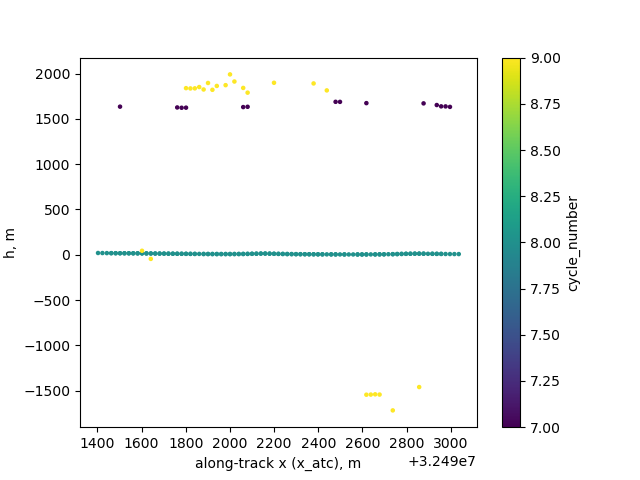

In [7]:
plt.figure()
hs=plt.scatter(D6_sub.x_atc, D6_sub.h_li,5, c=D6_sub.cycle)
plt.colorbar(hs, label='cycle_number')
plt.gca().set_xlabel('along-track x (x_atc), m')
plt.gca().set_ylabel('h, m')


If you're using the default location, this plot shows heights near zero for cycle 8, and elevations far above and below the surface for cycles 7 and 9.  If we zoom in on cycle 8, we can see something that looks like ice-shelf terrain, so we can guess that this is probably "right" and cycles 7 and 9 are wrong.  

### Getting ATL03 data for a problematic track

The next step is to look at the ATL03 photon cloud for each cycle to see what has worked and what has not.

:::{tip}
If you're running in interactive mode, copy the track (RGT) and pair track from the subsetted dataframe above.
:::

In [8]:
# set the rgt and pair track here:
this_rgt=1259
this_track=1

In [9]:
# Get ATL03.  this should take <1 minute to run.

icesat2.init("slideruleearth.io", True)
sliderule_ATL03_parms= {
    "poly":poly, 
    "t0": "2020-01-01T01:00:00Z",
    "t1": "2021-01-01T01:00:00Z",
    "rgt":this_rgt,
    "srt":icesat2.SRT_LAND_ICE,
    "cnf":-2,
    "track": this_track,
  }
# run sliderule for track
D3=sliderule.run('atl03x', sliderule_ATL03_parms).to_crs(3031)

# make a subset for our geographic region
D3_sub = D3.cx[xl[0]:xl[1], yl[0]:yl[1]]

Let’s plot the photons from ATL03, and the segments from ATL06 for each beam in pair 1 for each cycle.

Note that SlideRule has numeric codes for the different groundtracks, so

    gt=10 -> gt1l

    gt=20 -> gt1r

The SlideRule icesat2 module has ‘GT1L’,‘GT1R’,‘GT2L’ attributes that provide these numeric codes.


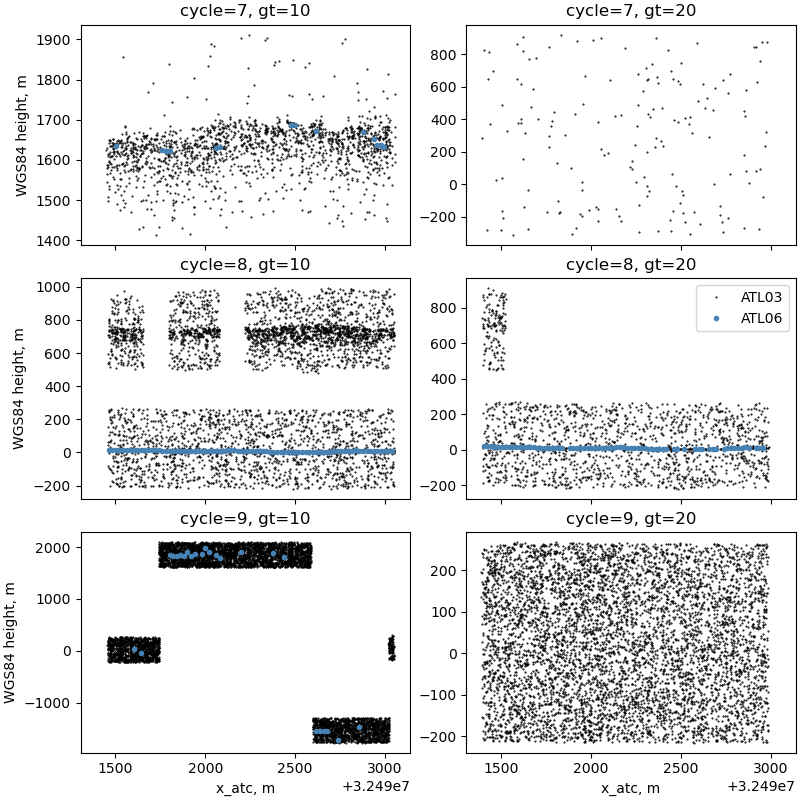

In [10]:
hf, hax= plt.subplots(3, 2, layout='constrained', sharex=True, figsize=[8, 8])

for ax1, cycle in zip(hax, np.unique(np.array(D6_sub.cycle))):
    for ax, gt in zip(ax1, np.unique(np.array(D6_sub['gt']))):
        i3=(D3_sub['gt']==gt) & (D3_sub.cycle==cycle)
        ax.plot(D3_sub.x_atc[i3], D3_sub.height[i3],'k.', markersize=1, label='ATL03')
        i6=(D6_sub['gt']==gt) & (D6_sub.cycle==cycle)
        ax.plot(D6_sub.x_atc[i6], D6_sub.h_li[i6],'.', color='steelblue', label='ATL06')
        ax.set_title(f'cycle={cycle}, gt={gt}')
hax[1, 1].legend()

for ax in hax[2,:]:
    ax.set_xlabel('x_atc, m')
for ax in hax[:,0]:
    ax.set_ylabel('WGS84 height, m')

We can see a few things going on here.  The photons in ATL03 come from vertical bands of data (_telemetry bands_) that the algorithms running onboard ATLAS have identified as possibly containing a ground return.  In some cases the algorithm is correct (e.g. cycle 8), in other cases it returns only a band of photons far from the ground (gt 10 for cycles 7 and 9) or returns a band of photons that contains the ground for which there is no usable return (gt 20 for cycles 7 and 9).

We can also see bands of photons above the ground in gt 10 for cycles 7 and 8: these are most likely clouds, and the photons in these bands are much farther apart than the photons from true ground returns (see cycle 8).

All of the tracks contain at least some background photons, which are uniformly distributed over the telemetry bands.  If you check the dates for the different cycles, you'll see that cycle 7 comes from June (Antarctic winter), cycle 8 comes from mid September (late winter / early spring) and cycle 9 comes from mid December (high summer).  As a result, there are very few background photons in cycle 7, and very many in cycle 9.


### Plotting ATL03 signal classifications

It's instructive to see how the ATL03 classification algorithm sees these points.  Let's do the plot again, but color code by signal classification.  These are stored in the ATL03 atl03_cnf field.  the confidence values are:

* -- -1: Events not associated with a specific surface type
* --  0: noise
* --  1: noise photons within a +-10 m vertical buffer of a detected photon
* --  2: low confidence signal
* --  3: medium confidence signal
* --  4: high confidence signal

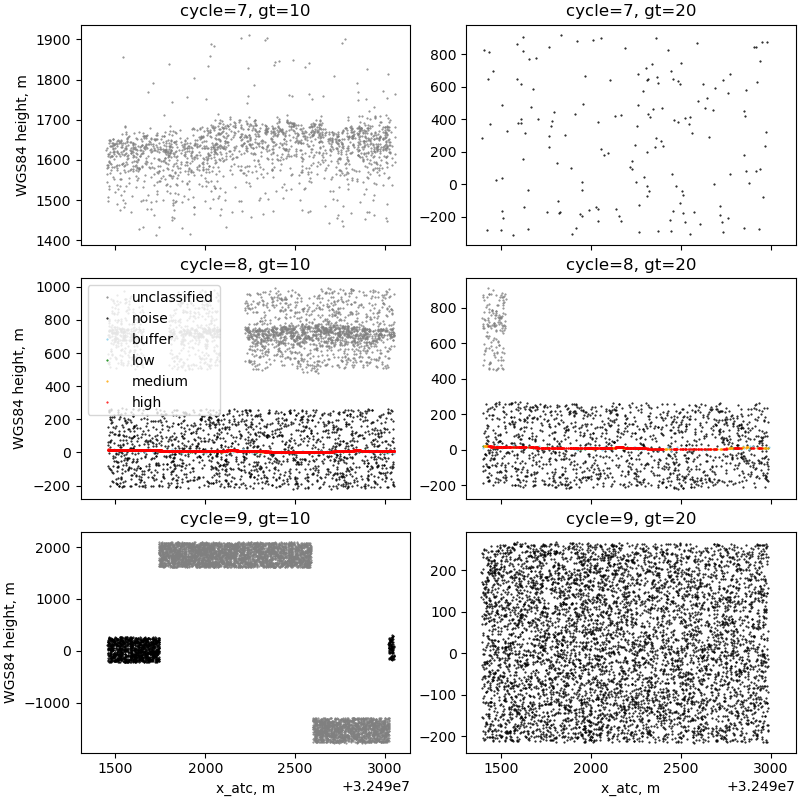

In [11]:
hf, hax= plt.subplots(3, 2, layout='constrained', sharex=True, figsize=[8, 8])

for ax1, cycle in zip(hax, np.unique(np.array(D6_sub.cycle))):
    for ax, gt in zip(ax1, np.unique(np.array(D6_sub['gt']))):
        for cnf, name, color in zip([-1, 0, 1, 2, 3, 4], ['unclassified', 'noise','buffer','low','medium','high'],['gray', 'black','skyblue','green','orange','red']):
            i3=(D3_sub['gt']==gt) & (D3_sub.cycle==cycle) & (D3_sub.atl03_cnf==cnf)
            ax.plot(D3_sub.x_atc[i3], D3_sub.height[i3],'.', markersize=1, color=color, label=name)
        ax.set_title(f'cycle={cycle}, gt={gt}')
hax[1, 0].legend()

for ax in hax[2,:]:
    ax.set_xlabel('x_atc, m')
for ax in hax[:,0]:
    ax.set_ylabel('WGS84 height, m')

If you zoom around a little bit, you'll see that cycles 7 and 9 have essentially all photons classified as noise, but cycle 8 has a mixture of high-confidence and (for gt==20) medium/low photons.  The low - confidence photons come from places where the surface is unusually dim, probably because of cloud attenuation.

## Relating cloud effects to ATL06 data parameters

Our problem comes when the ground return is not strong enough to trigger the signal finder, and we start to see triggers associated with:
- Cloud tops
- Random clusterings of background photons

These should both be statistically distinct from surface returns because:
- The returns are less intense than a high-quality surface return
- The photons are more widely vertcally spread than those in surface returns
- The surface window cannot converge on a small vertical window around the surface
- Surface heights and slopes are not consistent between adjacent segments

There are a few ATL06 parameters that help quantify these distinctions. 
- h_li_sigma : the estimated error in the surface-height estimate
- n_fit_photons : The number of photons found in each segment
- w_surface_window_final : The size of the converged surface window
- h_robust_sprd : A percentile-based estimate of the spread of the photons, corrected for background
- snr : the observed signal-to-noise ratio for the selected photons
- snr_significance : The estimated probability that a random clustering of photons would produce the observed SNR
- dh_fit_dx : the along-track segment slope
- r_eff : the effective reflectance of the surface

There's one more parameter that puts a few of these ideas together, in /gtxx/land_ice_segments:
- atl06_quality_summary : a combination of parameters (h_li_sigma, n_fit_photons/w_surface_window_final, and signal_selection_source).  Zero indicates a good segment, 1 indicates a possibly bad segment.

For most purposes selecting those points for which atl06_quality_summary==0 will filter out most of the bad returns.  Let's regenerate the map of Cook ice shelf to see how this works:


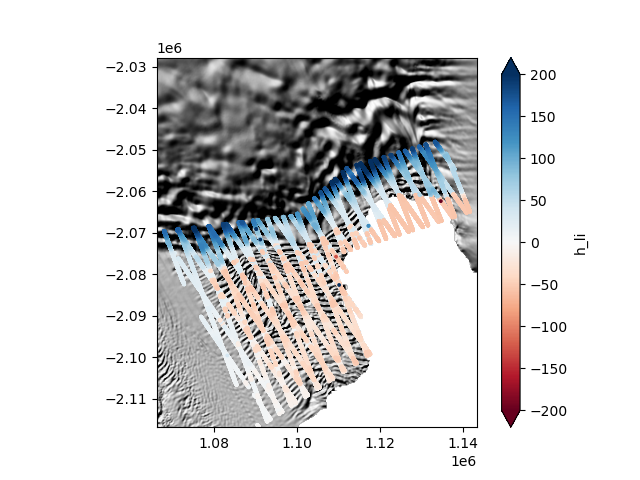

In [12]:
plt.figure()
ax_scat_clean = plt.gca()
plt.imshow(shaded_relief_img['data'], extent=shaded_relief_img['extent'])

xx=np.array(D6.geometry.x)
yy=np.array(D6.geometry.y)
hh = np.array(D6.h_li)
qq = np.array(D6.atl06_quality_summary)

# sort the data by abs(height) to make the outliers show up
ii=np.argsort(np.abs(hh))
# here is where we filter out the atl06_quality_summary==1 points
ii=ii[np.isfinite(hh[ii]) & (qq[ii]==0)]
h_scat_clean=plt.scatter(xx[ii], yy[ii], 3,  c=hh[ii], clim=[-200, 200], cmap='RdBu')
plt.colorbar(h_scat_clean, label='h_li', extend='both')


Presto!  all of the too-high and too-low returns from the first map are gone!

---

## Summary

We have taken a look at a location in Antarctica where ICESat-2 has (mostly) successfully measured surface elevations over an ice shelf.  The default code in the cells shows an example for one track, but by switching the 'interactive' variable above, you should be able to find different kinds features in the data.

If you have time, take a few minutes to go back to the first cell after __Getting ATL03 data for a problematic track__ and set ‘interactive’ to True. Then you can try zooming in on the map to identify the different tracks, and downloading the ATL03 to go with them (see the cell marked “select your track here”). You should be able to find:

    * Clouds
    * Crevasses
    * Rifts in the ice shelf
    * Sea ice or open water.
